# Import libraries and dataset

In [1412]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [1413]:
df = pd.read_csv(r"C:\Users\Cris\Documents\Repos\TitanicML\titanic_train.csv")

# Feature Engineering

In [1444]:
# Same tickes who don't have same last names????
# same_tickets = df.Ticket.value_counts()
# same_tickets = same_tickets[(same_tickets < 3)]
# same_tickets = same_tickets[(same_tickets > 1)].index.to_list()
# for ticket in same_tickets:
    # sub = df.groupby("Ticket").get_group(ticket)
    # print(sub.Name.to_list())

In [1445]:
# same_tickets = df.Ticket.value_counts()
# same_tickets[same_tickets > 2]
# family_size = []
# for id, ticket in enumerate(same_tickets.index.to_list()):
#     print(ticket, id)

In [1446]:
def remove_outliers(series, n):
    # n - determine magnitude of outlier (1.5 - normal, 3 - extreme)
    q3, q1 = series.quantile([0.75, 0.25])
    iqr = q3 - q1
    print("Límite de datos atípicos:", q3 + n*iqr)
    series = series.where(series < q3 + n*iqr)
    return series


In [1447]:
def standard_scale(series):
    return (series - series.mean())/series.std()

def min_max_scale(series):
    return (series - series.min())/series.max()

In [1448]:
def get_deck(data):
    # Transform Cabin column to a Deck dummy variables; obtain which Deck the cabin was in
    decks = ["A", "B", "C", "D", "E", "U"]
    for deck in decks:
        titanic_class = data.Cabin.str.contains(deck).astype(int)
        data["Deck_" + deck] = titanic_class

def fill_null(data):
    age_sample = data.Age[data.Age.notna()].sample(data.Age.isna().sum())
    data.Age.fillna(pd.Series(age_sample.to_list(), index=data.Age[data.Age.isna()].index), inplace=True)
    fare_sample = data.Fare[data.Fare.notna()].sample(data.Fare.isna().sum())
    data.Fare.fillna(pd.Series(fare_sample.to_list(), index=data.Fare[data.Fare.isna()].index), inplace=True)
    data.Cabin.fillna("U", inplace=True)

def scale_numeric(data, scaling):
    if scaling == "standard":
        data["Age"] = standard_scale(data.Age)
        data["Fare"] = standard_scale(data.Fare)
    elif scaling == "minmax":
        data["Age"] = min_max_scale(data.Age)
        data["Fare"] = min_max_scale(data.Fare)

def get_dummy_variables(data):
    data["Sex"] = pd.get_dummies(data.Sex)["female"]      # Turn sex into one-hot, 1 is female, 0 is male
    data[["Class1", "Class2", "Class3"]] = pd.get_dummies(data.Pclass)    # Ticket Class to dummy variables
    data[["Cherbourg", "Queenstown", "Southampton"]] = pd.get_dummies(data.Embarked)      # Embarked to dummy variables

def get_family_size(data):
    same_tickets = data.Ticket.value_counts()
    family_size = []
    for ticket in data.Ticket:
        family_size.append(same_tickets[ticket])
    data["FamSize"] = family_size

def get_lone_travelers(data):
    alone = (data.SibSp < 1) & (data.Parch < 1)       # Generate Lone traveler variable
    data["Alone"] = alone.astype(int)

def box_cox_transform(data):
    data["Fare"], _ = stats.boxcox(data.Fare + 1e-2)
    data["Age"], _ = stats.boxcox(data.Age + 1e-2)

In [1449]:
def get_titles(data):
    titles = ["Mr.", "Mrs.", "Miss.", "Master."]
    for title in titles:
        data[title.replace(".", "")] = data.Name.str.contains(title, regex=False).astype(int)
    return data

In [1450]:
def perform_pca(data):
    cols = data.corr(numeric_only=True).columns
    dfs = data[cols]
    scaler = StandardScaler()
    dfs = scaler.fit_transform(dfs)
    dfs = pd.DataFrame(dfs, columns = cols)
    R = dfs.corr()
    lam, v = np.linalg.eig(R)
    M = np.array(dfs[cols])
    PCA = (v @ M.T)
    PCA = pd.DataFrame(PCA.T)
    return PCA

In [1451]:
def data_pipeline(dataframe):

    # Call functions without redifining "dataframe"? Can inplace=True access the argument?
    fill_null(dataframe)
    # One-hot encoding of categorical data
    get_dummy_variables(dataframe)
    # Feature extraction
    get_lone_travelers(dataframe)
    # get_family_size(dataframe)
    # get_deck(dataframe)
    # get_titles(dataframe)

    # if dataframe.PassengerId[0] < 891:
    #     dataframe["Fare"] = remove_outliers(dataframe.Fare, 3)
    #     dataframe.dropna(inplace=True)
    #     dataframe["Age"] = remove_outliers(dataframe.Age, 1.5)
    #     dataframe.dropna(inplace=True)

    # box_cox_transform(dataframe)
    scale_numeric(dataframe, scaling="minmax")
    
    dataframe.drop(columns=["Pclass", "Name", "Ticket", "Cabin", "Embarked", "PassengerId"], inplace=True)

    # dataframe = perform_pca(dataframe)

    return dataframe

In [1452]:
# Feature extraction idea: family divisions? Lone travelers?
# df[df.Name.str.contains("Palsson")]
# df[(df.SibSp < 2) & (df.Parch > 2)]

# Travel alone category
# Parent, number of children
# Child, number of siblings

In [1453]:
# df.Ticket.value_counts()[0:19]

In [1454]:
# for ticket in same_tickets:
#     sub = df.groupby("Ticket").get_group(ticket)
#     print(sub.Cabin.to_list())

In [ ]:
x_train = data_pipeline(df.drop(columns=["Survived"]))
y_train = df.Survived
x_train.info()

## Variable Correlation

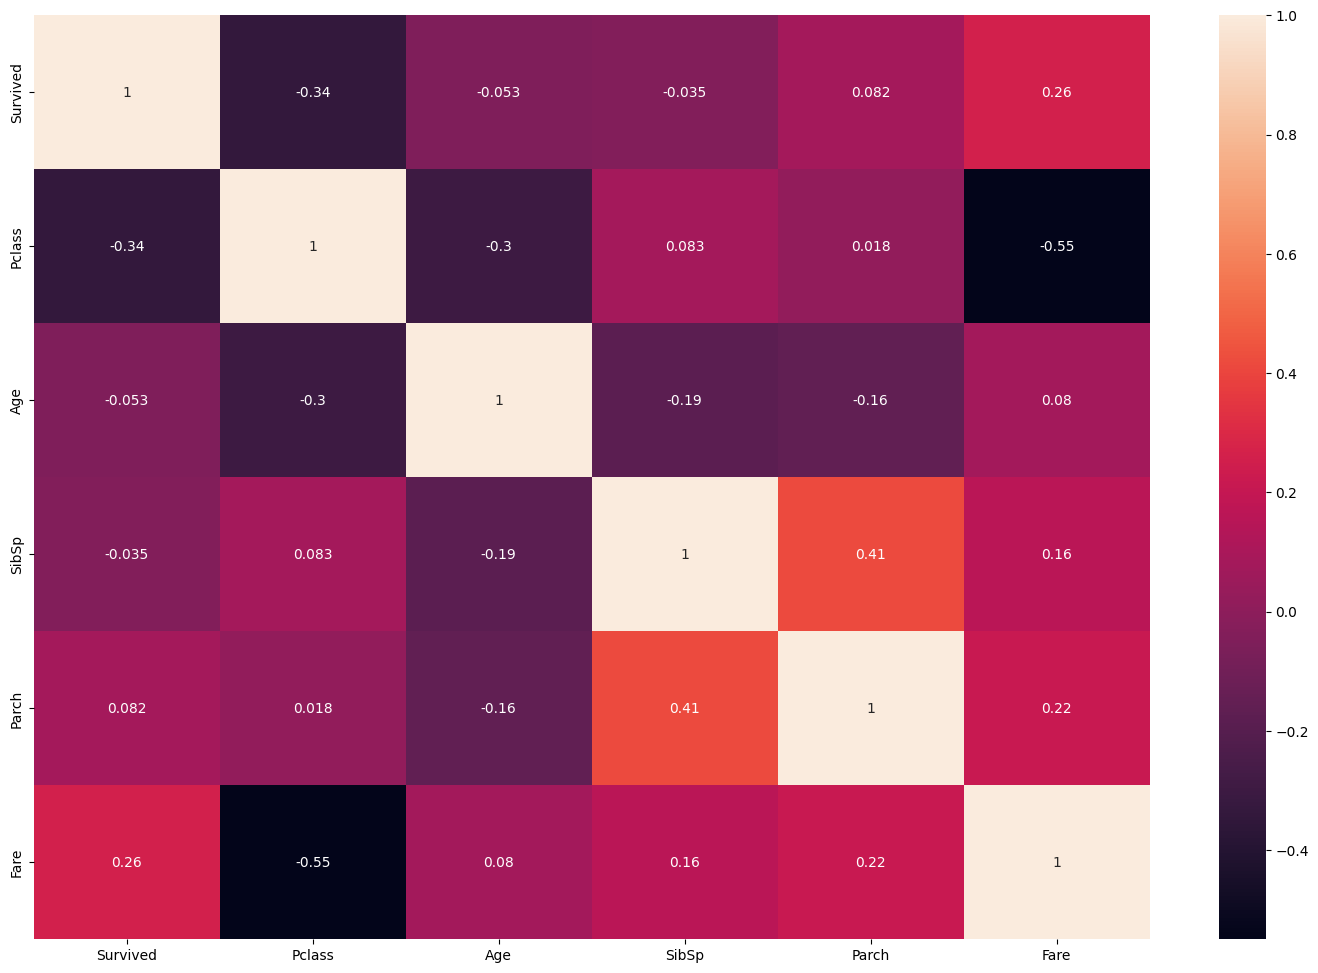

In [1455]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(df.drop(columns="PassengerId").corr(numeric_only=True), annot=True)
plt.show()